In [1]:
import pandas as pd
import numpy as np
import pm4py
from variant_stats import get_variants_stats
from pm4py.util import ml_utils
import importlib.util
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from sklearn.cluster import SpectralClustering

In [2]:
df2 = pd.read_pickle('decision_paths/subset_optimized_simple_size_0.2_fitnessweights_p0.34_f0.33_c0.33_weightmodel_weight_positive_simplified.pickle')

# Initialize an empty list to hold event log rows
event_log0 = []
event_log1 = []

# Iterate over each decision path in the dataset
timestamp = pd.Timestamp('2024-11-14')
case_id = -1
for i in range(len(df2)):
    data = df2['rule_to_simplified_rules'].iloc[i]
    for path in data:
        case_id += 1
        for t,step in enumerate(path):
            # Create an event dictionary for the current step
            event = {
                'case_id': case_id,
                'activity': step.get('feature_value'),
                'timestamp': timestamp + pd.Timedelta(days=t)
            }
            # if event['activity'] in to_remove:
            #     # print(f" I removed {event['activity']} from the log")
            #     continue
            if pd.isna(event['activity']):
                event['activity'] = f'predict{step['predict']}'

            
            # Append the event to the event log
            if path[-1]['predict'] == 1:
                event_log1.append(event)
            else:
                event_log0.append(event)

event_log1 = pd.DataFrame(event_log1)
event_log0 = pd.DataFrame(event_log0)
log1 = event_log1.copy()
log1.rename(columns={'timestamp': 'time:timestamp', 'case_id': 'case:concept:name', 'activity': 'concept:name'}, inplace=True)

log0 = event_log0.copy()
log0.rename(columns={'timestamp': 'time:timestamp', 'case_id': 'case:concept:name', 'activity': 'concept:name'}, inplace=True)

df0 = get_variants_stats(log0)
df1 = get_variants_stats(log1)

In [30]:
trace_strings = [' '.join(trace) for trace in df0['sequence']]

from sklearn.feature_extraction.text import TfidfVectorizer
# Apply TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(trace_strings)  # X is a matrix (n_traces x n_activities)

# Check the shape and feature names
print("TF-IDF Matrix shape:", X.shape)

TF-IDF Matrix shape: (802, 154)


In [31]:
Y=X.copy()

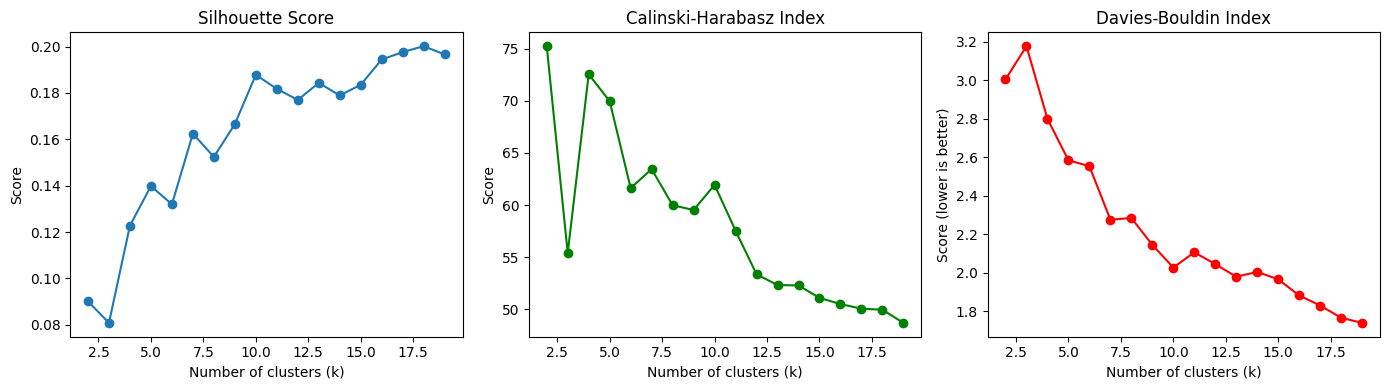

In [20]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt

X = np.array(X.todense())

# Initialize lists to store metric scores
silhouette_scores = []
calinski_scores = []
davies_scores = []
k_values = range(2, 20)

# Calculate scores for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, labels))
    calinski_scores.append(calinski_harabasz_score(X, labels))
    davies_scores.append(davies_bouldin_score(X, labels))

# Plot the metrics
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Score')

plt.subplot(1, 3, 2)
plt.plot(k_values, calinski_scores, marker='o', color='green')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Score')

plt.subplot(1, 3, 3)
plt.plot(k_values, davies_scores, marker='o', color='red')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Score (lower is better)')

plt.tight_layout()
plt.show()


Computing gap statistic: 100%|█████████████████████████████████████████████████████████| 25/25 [00:02<00:00,  8.67it/s]


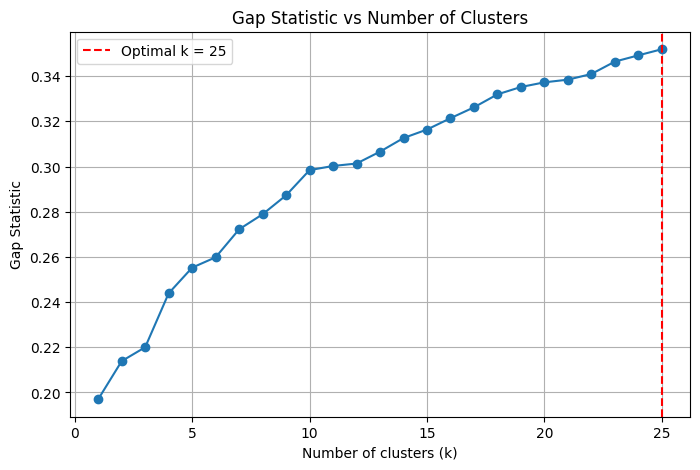

In [43]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from tqdm import tqdm  # Optional progress bar

def compute_gap_statistic(X, max_k=25, n_refs=8):
    shape = X.shape
    tops = X.max(axis=0)
    bots = X.min(axis=0)
    dists = tops - bots

    # Pre-generate reference datasets
    refs = [np.random.rand(*shape) * dists + bots for _ in range(n_refs)]

    gaps = []
    for k in tqdm(range(1, max_k + 1), desc="Computing gap statistic"):
        # Dispersion for reference datasets
        ref_disps = []
        for ref_data in refs:
            km = KMeans(n_clusters=k, n_init='auto', random_state=42).fit(ref_data)
            ref_disp = np.mean(np.min(cdist(ref_data, km.cluster_centers_), axis=1))
            ref_disps.append(ref_disp)
        mean_ref_disp = np.mean(ref_disps)

        # Dispersion for real data
        km_real = KMeans(n_clusters=k, n_init='auto', random_state=42).fit(X)
        real_disp = np.mean(np.min(cdist(X, km_real.cluster_centers_), axis=1))

        # Gap = log(expected) - log(observed)
        gap = np.log1p(mean_ref_disp) - np.log1p(real_disp)
        gaps.append(gap)

    optimal_k = np.argmax(gaps) + 1
    return gaps, optimal_k

# Example usage (replace Y with your TF-IDF or encoded matrix)
X = np.array(Y.todense())
gaps, best_k = compute_gap_statistic(X, max_k=25)

# Plotting (if you want to visualize)
def plot_gap_statistic(gaps, optimal_k):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(gaps) + 1), gaps, marker='o')
    plt.axvline(optimal_k, linestyle='--', color='red', label=f'Optimal k = {optimal_k}')
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Gap Statistic")
    plt.title("Gap Statistic vs Number of Clusters")
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_gap_statistic(gaps, best_k)